<a href="https://colab.research.google.com/github/sazio/MultiAgentCovid/blob/master/Multiplex_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data and match Agents with Buildings

In [163]:
import numpy as np
import pandas as pd 
import glob 
from tqdm.notebook import tqdm 
from scipy import sparse
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [81]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [82]:
path = "drive/MyDrive/MAS/Data/Output_GAMA/Data"

agents_path = path + "/Agents"
buildings_path = path + "/Buildings"

agents_files = glob.glob(agents_path + "/*.csv")
buildings_file = glob.glob(buildings_path + "/*.csv")

agents_1_day = [agents_files[i] for i in range(0,24)]

In [5]:
DF_buildings = pd.read_csv(buildings_file[0], sep = ",", names = ["name", "loc_x", "loc_y", "loc_z"])
DF_buildings = DF_buildings.iloc[1:]
DF_buildings = DF_buildings.reset_index(drop = True)
DF_buildings["name"] = DF_buildings["name"].str[:8] + "(" + DF_buildings["name"].str[8:] + ")"
DF_buildings["loc_x"] = DF_buildings["loc_x"].str[1:].astype(np.float32)
DF_buildings["loc_y"] = DF_buildings["loc_y"].astype(np.float32)
DF_buildings["loc_z"] = DF_buildings["loc_z"].str[:-1].astype(np.float32)

DF_buildings.head()

,name,loc_x,loc_y,loc_z
0,building(0),4258.587891,8622.923828,0.0
1,building(1),4205.688477,8554.613281,0.0
2,building(2),4172.957031,8508.589844,0.0
3,building(3),4653.243164,8230.745117,0.0
4,building(4),4630.689941,8173.111816,0.0


In [274]:
# First Agents file as example (ToDo --> function from this stuff)
DF_agents = pd.read_csv(agents_files[0], sep = ",", names = ["name", "cycle","loc_x", "loc_y", "loc_z","living_place",
"working_place","stuff_place", "is_susceptible", "is_infected", "is_immune"])
DF_agents = DF_agents.iloc[1:]
DF_agents = DF_agents.reset_index(drop = True)
DF_agents["loc_x"] = DF_agents["loc_x"].str[1:].astype(np.float32)
DF_agents["loc_y"] = DF_agents["loc_y"].astype(np.float32)
DF_agents["loc_z"] = DF_agents["loc_z"].str[:-1].astype(np.float32)

DF_agents = DF_agents.replace({"is_susceptible":{"true":True, "false":False}})
DF_agents = DF_agents.replace({"is_infected":{"True":True, "False":False}})
DF_agents = DF_agents.replace({"is_immune":{"True":True, "False":False}})

DF_agents = DF_agents[DF_agents.living_place != "nil"]
DF_agents = DF_agents[DF_agents.working_place != "nil"]
DF_agents = DF_agents[DF_agents.stuff_place != "nil"]

DF_agents.head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,stuff_place,is_susceptible,is_infected,is_immune
0,people0,401,4047.333740,2014.397461,0.0,building(1408),building(220),building(3381),False,False,True
1,people1,401,1911.168823,3917.855225,0.0,building(1350),building(5862),building(6186),False,True,False
2,people2,401,3277.526123,657.434082,0.0,building(2112),building(84),building(6398),True,False,False
3,people3,401,3803.600098,1790.961182,0.0,building(5496),building(5860),building(6211),True,False,False
4,people4,401,3402.263672,7576.838379,0.0,building(1101),building(266),building(2286),True,False,False


In [277]:
def is_in_which_building(DF_buildings, DF_agents, agent_index):

  """
  Check if the agent is in some building or in the street (if alive), useful to build a multiplex network 

  """
  # In case some of the locations are "nil", i.e. non existing, it basically means that our agent is dead
  if DF_agents.values[agent_index,5]  == "nil":
    return "Dead"

  elif DF_agents.values[agent_index,6] == "nil":  
    return "Dead"

  elif DF_agents.values[agent_index,7] == "nil": 
    return "Dead"

  # In case our agent is alive 
  else:

    living_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,5]].values[0][1:3]
    working_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,6]].values[0][1:3]
    stuff_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,7]].values[0][1:3]

    agent_coord = DF_agents.values[agent_index,2:4]

    liv_ag_dist = np.linalg.norm(living_coord - agent_coord)
    wor_ag_dist = np.linalg.norm(working_coord - agent_coord)
    stu_ag_dist = np.linalg.norm(stuff_coord - agent_coord)

    if min(liv_ag_dist, wor_ag_dist, stu_ag_dist) == liv_ag_dist and liv_ag_dist < 50:

      return DF_agents.values[agent_index,5]

    elif  min(liv_ag_dist, wor_ag_dist, stu_ag_dist) == wor_ag_dist and wor_ag_dist < 50:

      return DF_agents.values[agent_index,6]

    elif  min(liv_ag_dist, wor_ag_dist, stu_ag_dist) == stu_ag_dist and stu_ag_dist < 50:

      return DF_agents.values[agent_index,7]

    # In case our agent is on the road to some place 
    else: 

      return "None"

In [278]:
# ToDo, iterrows is not the most efficient, find a faster way (e.g. apply)
for index,row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
    DF_agents.loc[index,'current_location'] = is_in_which_building(DF_buildings, DF_agents, agent_index = index)

In [279]:
DF_agents[DF_agents.current_location.duplicated()].head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,stuff_place,is_susceptible,is_infected,is_immune,current_location
6,people6,401,2042.102539,3271.883545,0.0,building(6504),building(5664),building(1325),False,False,True,None
10,people10,401,3804.095215,1785.334595,0.0,building(1800),building(336),building(6211),True,False,False,building(6211)
13,people15,401,3664.964355,2534.839355,0.0,building(2221),building(260),building(6446),True,False,False,None
14,people16,401,4290.428223,4583.939941,0.0,building(6702),building(1228),building(6186),False,False,True,None
18,people20,401,3480.477539,395.809479,0.0,building(5497),building(222),building(1325),False,False,True,None


In [87]:
DF_agents[DF_agents.current_location == "building(6211)"].head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,stuff_place,is_susceptible,is_infected,is_immune,current_location
3,people3,401,3803.600098,1790.961182,0.0,building(5496),building(5860),building(6211),True,False,False,building(6211)
10,people10,401,3804.095215,1785.334595,0.0,building(1800),building(336),building(6211),True,False,False,building(6211)
62,people69,401,3817.859375,1793.564697,0.0,building(904),building(2088),building(6211),False,False,True,building(6211)
90,people101,401,3826.621826,1795.730347,0.0,building(1330),building(306),building(6211),True,False,False,building(6211)
100,people117,401,3827.175537,1791.492920,0.0,building(1418),building(2241),building(6211),False,False,True,building(6211)


# Multiplex Analysis

In [103]:
#!pip install git+https://github.com/nkoub/multinetx.git

In [89]:
import multinetx as mx

In [271]:
# Create weighted links in the same network 

2216.8833

In [333]:
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  DF_agents.loc[index, "x_liv"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].living_place])].loc_x.values[0]
  DF_agents.loc[index, "y_liv"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].living_place])].loc_y.values[0]

  DF_agents.loc[index, "x_wor"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].working_place])].loc_x.values[0]
  DF_agents.loc[index,  "y_wor"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].working_place])].loc_y.values[0]

  DF_agents.loc[index, "x_stu"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place])].loc_x.values[0]
  DF_agents.loc[index, "y_stu"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place])].loc_y.values[0]

## Adjacency matrix for each layer 

In [282]:
# ToDo: make it faster by vectorization (especially for larger matrices), add weights based on current_location
living_adj = np.eye(DF_agents.shape[0])

for i in tqdm(range(0,living_adj.shape[0])):
  for j in range(0,living_adj.shape[0]):

    if DF_agents.loc[i].living_place == DF_agents.loc[j].living_place:
      living_adj[i,j] = 1  

    else: 
      living_adj[i,j] = 0 

In [283]:
sparse_living_adj = sparse.csr_matrix(living_adj)
sparse.save_npz(path + '/sparse_living_adj.npz', sparse_living_adj)

In [284]:
#  ToDo: make it faster by vectorization 
working_adj = np.eye(DF_agents.shape[0])

for i in tqdm(range(0,working_adj.shape[0])):
  for j in range(0,working_adj.shape[0]):

    if DF_agents.loc[i].working_place == DF_agents.loc[j].working_place:
      working_adj[i,j] = 1  

    else: 
      working_adj[i,j] = 0 

In [285]:
sparse_working_adj = sparse.csr_matrix(working_adj)
sparse.save_npz(path + '/sparse_working_adj.npz', sparse_working_adj)

In [286]:
#  ToDo: make it faster by vectorization 
stuff_adj = np.eye(DF_agents.shape[0])

for i in tqdm(range(0,stuff_adj.shape[0])):
  for j in range(0,stuff_adj.shape[0]):

    if DF_agents.loc[i].stuff_place == DF_agents.loc[j].stuff_place:
      stuff_adj[i,j] = 1  

    else: 
      stuff_adj[i,j] = 0 

In [294]:
sparse_stuff_adj = sparse.csr_matrix(stuff_adj)
sparse.save_npz(path + '/sparse_stuff_adj.npz', sparse_stuff_adj)

## InterAdjacency matrix 
(connections between layers)

In [295]:
inter_adj = mx.lil_matrix(np.zeros((DF_agents.shape[0]*3,DF_agents.shape[0]*3)))

inter_adj[0:  DF_agents.shape[0],  DF_agents.shape[0]:2*DF_agents.shape[0]] = np.identity(DF_agents.shape[0])    # Layer 1 to 2 
inter_adj[0:  DF_agents.shape[0],2*DF_agents.shape[0]:3*DF_agents.shape[0]] = np.identity(DF_agents.shape[0])    # Layer 1 to 3
inter_adj[DF_agents.shape[0]:2*DF_agents.shape[0],2*DF_agents.shape[0]:3*DF_agents.shape[0]] = np.identity(DF_agents.shape[0])    # Layer 2 to 3 
    
# symmetric inter-adjacency matrix
inter_adj += inter_adj.T

In [317]:
unique, counts = np.unique(stuff_adj, return_counts=True)
dict(zip(unique, counts))

{0.0: 1029928, 1.0: 134313}

In [318]:
unique, counts = np.unique(living_adj, return_counts=True)
dict(zip(unique, counts))

{0.0: 1162948, 1.0: 1293}

In [319]:
unique, counts = np.unique(working_adj, return_counts=True)
dict(zip(unique, counts))

{0.0: 1159050, 1.0: 5191}

## Multiplex Instance 

In [310]:
living_graph = mx.from_scipy_sparse_matrix(sparse_living_adj)
working_graph = mx.from_scipy_sparse_matrix(sparse_working_adj)
stuff_graph = mx.from_scipy_sparse_matrix(sparse_stuff_adj)

In [311]:
multi_net = mx.MultilayerGraph(list_of_layers=[living_graph, working_graph, stuff_graph],
                        inter_adjacency_matrix= inter_adj)


multi_net.set_edges_weights(inter_layer_edges_weight=0.1)

# ToDo set weights based on daily interaction time 
multi_net.set_intra_edges_weights(layer=0,weight=1)
multi_net.set_intra_edges_weights(layer=1,weight=2)
multi_net.set_intra_edges_weights(layer=2,weight=3)

In [361]:
x_coord = DF_agents.loc_x.to_dict()
y_coord = DF_agents.loc_y.to_dict()

"""
# First layer = living place 
x_coord = DF_agents.x_liv.to_dict()
y_coord = DF_agents.y_liv.to_dict()

#second layer = working place 
x_coord1 = DF_agents.x_wor.to_dict()
y_coord1 = DF_agents.y_wor.to_dict()

#third layer  = stuff place 
x_coord2 = DF_agents.x_stu.to_dict()
y_coord2 = DF_agents.y_stu.to_dict() 

for i in range(0,DF_agents.shape[0]):
  x_coord1[DF_agents.shape[0] + i] = x_coord1.pop(i)
  y_coord1[DF_agents.shape[0] + i] = y_coord1.pop(i)

for i in range(0,DF_agents.shape[0]):
  x_coord2[DF_agents.shape[0]*2 + i] = x_coord2.pop(i)
  y_coord2[DF_agents.shape[0]*2+ i] = y_coord2.pop(i)


x_coord.update(x_coord1)
x_coord.update(x_coord2)

y_coord.update(y_coord1)
y_coord.update(y_coord2)""";

In [362]:
def merge_dict(dict1, dict2):
    ''' 
    Merge dictionaries and keep values of common keys in list
    '''
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = np.array([value , dict1[key]])
    return dict3

In [363]:
pos_coord = merge_dict(x_coord, y_coord)

pos = mx.get_position(multi_net,pos_coord,
					  layer_vertical_shift=5000,
					  layer_horizontal_shift= 2000,
					  proj_angle= 90 )

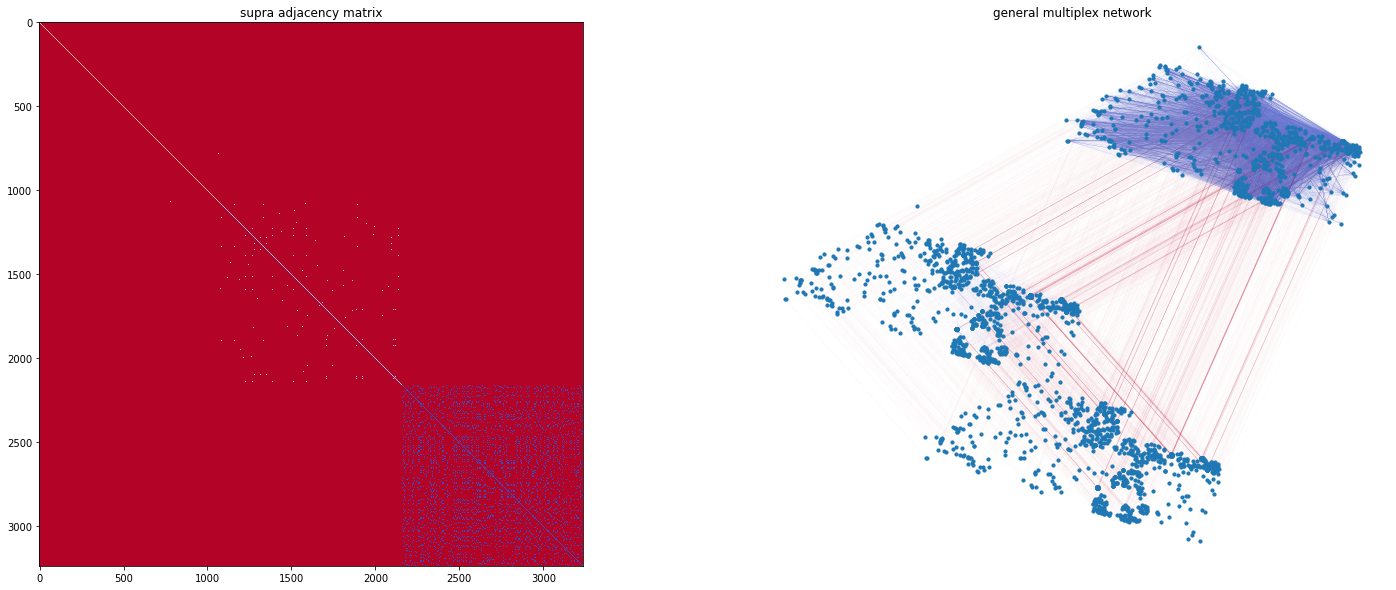

In [365]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(multi_net,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.coolwarm_r)
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('general multiplex network')

mx.draw_networkx(multi_net,pos=pos,ax=ax2,node_size=10,with_labels=False,
				 edge_color=[multi_net[a][b]['weight'] for a,b in multi_net.edges()],
				 edge_cmap=plt.cm.coolwarm_r, width = 0.01)

# Save just the portion _inside_ the second axis's boundaries
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Multiplex_Toronto.png', bbox_inches=extent)

plt.show()